# Figure 4 (Part 2). Dynamic (Short-Term) Modulation of Timescale During Working Memory
In this notebook, we look at the modulation of neuronal timescale in the human frontal cortex during a visuospatial working memory task.

---
So far, our data has shown that (spatial) variations in neuronal timescale is related to anatomical gradients in the cortex, both gene expression and local connectivity (grey matter myelination). In addition, timescale changes over aging, as one would expect if the underlying brain anatomy is changing via alteration and loss of specific cell types or synapses (e.g., GluN2B, see [Pagasiou et al., 2019][pegasiou2019]). As such, different cortical areas should have a clear division of roles: areas with short vs. long intrinsic timescales (i.e., sensory vs. association) should be "responsible" for short- vs. long- timescale information relevant for behavior, respectively. In other words, a cortical area should only "accept" a computation if its intrinsic timescale satisfies what's required by the task, and pass it onto another brain region with more appropriate timescales if not. Previous findings in animal studies have supported this, showing region-specific segregation of task information during decision-making ([Runyan et al., 2017][runyan2017]) and working memory ([Wasmuht et al., 2017][wasmuht2017]) tasks.

Under this view, however, the timescale of each cortical region is rigidly defined by its anatomy, which does not change. An alternative possibility is that region-specific timescales can also be dynamically modulated by real-time behavioral requirements, i.e., a circuit will have an intrinsic timescale _range_ that is defined largely by its anatomy, and reflected in its resting-state dynamics. When recruited for a behavior, however, the circuit can move within its range of timescales as required, possibly as a function of the neuromodulators acting within those regions.

Here, we test whether cortical timescales can be behaviorally-modulated. We analyze another publically available human ECoG dataset where 15 subjects are performing a visuospatial working memory task that requires a delayed response ([Johnson et al., 2018][johnson2018]). We aggregate over task conditions in the original study and simply ask whether neuronal timescale in the frontal cortices (prefrontal-PFC, orbitofrontal-OFC) and other regions (medial temporal/hippocampal-MTL, Parietal Cortex-PC) are different between resting (pre-stimulus) and memory maintenance (delay), both of which were absent of visual stimuli. We hypothesized that, since participants are required to hold onto information for task-response later, timescale of neuronal activity in frontal regions should be longer during delay period than pre-stimulus period, possibly reflecting an increase of recurrent activity.

---
ECoG data is taken from CRCNS datasets [fcx-2 and fcx-3][crcnsfcx]. The two datasets have 15 unique subjects total, with OFC, PFC, MTL, and parietal region coverage, performing the same task. See original[ publication][johnson2018] and data repository for detailed descriptions of the task and dataset. Briefly, each trial has one pre-stimulus epoch and two encoding epochs. We performed Hamming-windowed Fourier Transform on the last 900ms of data in each epoch to avoid stimulus-offset related ERPs, extracted timescale estimates from the PSD, and averaged the two delay periods. We compare timescale difference between delay and baseline period by taking their log-ratio. This was performed for each trial and channel separately, and timescale changes were then averaged across channels for a per-trial timescale difference. One-sample, two-tailed t-test was performed on timescale ratio over all trials for each subject, for a per-subject t-value of difference. We also average over all trials to get per-subject timescale differences (`'tau_tval'` and `'tau_diff'` in the dataframe below). This was repeated for other fooof-fitted PSD parameters (offset and exponent), as well as theta (3-8Hz) and high-frequency activity (HFA, 70-100Hz) power, for model comparison. 

Code for computing single-trial features are in `./4_analysis_human_wm.ipynb`. This notebook contains code for aggregating and performing statistics on the pooled data.

---
#### TL;DR: 
We hypothesized that neuronal timescale is not rigidly constrained by a circuit's structural properties, but can also be modulated dynamically by behavior. We find that, indeed, ECoG timescales in all regions are longer during the delay period of a working memory task than pre-stimulus baseline, but the amount of timescale increase is strongly related to working memory performance in PFC only, and not in PC, OFC, or MTL.

[pegasiou2019]:http://dx.doi.org/10.1101/2020.01.21.913475
[runyan2017]: https://www.nature.com/articles/nature23020
[wasmuht2017]: https://www.nature.com/articles/s41467-018-05961-4
[johnson2018]: https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2004274
[crcnsfcx]: https://crcns.org/data-sets/fcx

In [1]:
%load_ext autoreload
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pickle
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp, pearsonr, spearmanr, ttest_ind
import statsmodels.formula.api as smf
from numpy import log10

# custom
import sys
sys.path.append('../')
import echo_utils

# plotting stuff
import matplotlib.pyplot as plt
from matplotlib import gridspec
from seaborn import despine

# plot settings
font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 14}

plt.rc('font', **font)
fig_path = '../figures/jwm/%s.pdf'
save_plot=True

C_ORD = plt.rcParams['axes.prop_cycle'].by_key()['color']

********************************************************************************
         to build the TVTK classes (8.2). This may cause problems.
         Please rebuild TVTK.
********************************************************************************



In [2]:
def compute_pre_enc(df_sub):
    """
    Pool single trial data into dataframes containing aggregated pre, encoding, and difference.
    """
    df_pre = df_sub[df_sub['cond']==0].copy().reset_index(drop=True, inplace=False)
    df_enc = ((df_sub[df_sub['cond']==1]+df_sub[df_sub['cond']==2].values)/2).copy().reset_index(drop=True, inplace=False)

    # make datafraom of differences 
    df_diff = pd.DataFrame(index=df_pre.index, columns=df_pre.columns)
    df_diff[['patient', 'cond', 'trial', 'chan']] = df_pre[['patient', 'cond', 'trial', 'chan']]
    df_diff['cond'] = 2.

    ## COULD JUST REMOVE THIS WEIRD THING HERE BY LOGGING TAUS BEFORE
    # take diff for all features
    df_diff[feature_names] = df_enc[feature_names].values - df_pre[feature_names].values
    # take log ratio for tau
    df_diff['tau'] = log10(df_enc['tau'].values / df_pre['tau'].values) 

    # aggregate results
    df_res = []
    for df_cond in [df_pre, df_enc, df_diff]:
        df_res.append(df_cond.groupby('patient').agg(['mean', 'sem']).drop(['trial', 'chan'], axis=1))

    # meta-info
    df_info = pd.DataFrame(index=np.unique(df_sub['patient']), columns=['n_trials', 'n_chans'])
    df_info.index.name='patient'
    for i_p, p in df_sub.groupby('patient'):
        df_info.loc[i_p] = (len(np.unique(p['trial'])), len(np.unique(p['chan'])))

    return df_res, df_info


# Single-trial fits of timescale
Collect FOOOF fits, merge all single trials into one big dataframe, and throw out tau & exponent values that are way outside the limit of reasonable values.

In [3]:
# load metadata
df_patient_info = pd.read_csv('../data/df_johnson_patient_info.csv', index_col=0)
df_electrode_info = pd.read_csv('../data/df_johnson_electrode_info.csv')
result_path = '../data/johnson/'

# load data features
feature_names = ['offset', 'exp', 'knee', 'tau', 'theta', 'hfa']
feature_list = []
for ff in feature_names:
    print(ff, end='| ')
    with open(result_path + "all_%s.txt"%ff, "rb") as fp: # unpickling
        feature_list.append(pickle.load(fp))

# collect all trials into df
col_names = ['patient', 'cond', 'trial', 'chan', 'region'] + feature_names
df_alltrials = pd.DataFrame(columns=col_names)

# s3 has really bad data (see PSDs), s15 & s17 are same as s5 & s8
patient_id = range(1,18) # patients go from s1-s17
#patient_inds = [0,1,3,4,5,6,7,8,9,10,11,12,13,15] # drop 2, 14, 16 (s3, s15, s17)
patient_inds = [0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16] # drop 2, 14, 16 (s3, s15, s17)

# collect into a big dataframe, one row for each trial of every patient and electrode
for i_p in patient_inds:
    patient_mat = patient_id[i_p]*np.ones_like(feature_list[0][i_p])
    nchans, ntrials = feature_list[0][i_p][0].shape
    # make channel metadata matrices
    cond_mat = np.ones_like(feature_list[0][i_p])*np.array([0,1,2])[:,None,None]
    trial_mat = np.repeat(np.outer(np.ones((nchans,1)), np.arange(ntrials)[None,:])[None,:,:], 3, axis=0)
    chan_mat = np.repeat(np.outer(np.ones((ntrials,1)), np.arange(nchans)[None,:]).T[None,:,:], 3, axis=0)
    region_mat = df_electrode_info[df_electrode_info['patient']=='s%i'%patient_id[i_p]]['region'].values[chan_mat.astype(int)]
    
    ft_agg = [patient_mat.flatten(), cond_mat.flatten(), trial_mat.flatten(), chan_mat.flatten(), region_mat.flatten()]
    # unpack feature and collect into df
    for ft in feature_list:
        ft_agg.append(ft[i_p].flatten())
    df_cur = pd.DataFrame(np.array(ft_agg).T, columns=col_names)
    df_alltrials = df_alltrials.append(df_cur, ignore_index=True)

# set all trials with really bad slope fits (must be between 0 and 8) and tau fits (between 0 and 1) to nan to be excluded during analysis later
df_alltrials.loc[((df_alltrials['exp']<0) | (df_alltrials['exp']>8)| (df_alltrials['tau']<=0) | (df_alltrials['tau']>1)), feature_names] = np.nan

# reset patient info index to floats
df_patient_info.index = [float(s[1:]) for s in df_patient_info.index]

offset| exp| knee| tau| theta| hfa| 

In [109]:
# s3 has really bad data (see PSDs), s15 & s17 are same as s5 & s8
df_patient_info

,age,sex,acc_identity,acc_spatial,acc_temporal,rt_identity,rt_spatial,rt_temporal,sampling_rate
1.0,33.0,F,0.900,0.950,0.850,1947.968750,1844.540541,1556.852941,1000
2.0,50.0,M,0.950,0.975,0.975,1155.111111,1092.236842,1169.378378,1000
3.0,69.0,F,0.925,0.775,0.750,2248.888889,1432.200000,1481.500000,1000
4.0,31.0,M,0.925,0.925,0.950,1562.411765,1740.277778,2069.567568,1000
5.0,22.0,M,0.825,0.800,0.750,3174.531250,2535.322581,3142.178571,1000
6.0,31.0,M,0.925,1.000,0.925,1685.702703,962.925000,1088.351351,1000
7.0,34.0,M,0.900,1.000,0.975,779.371429,740.131579,647.594595,1000
8.0,27.0,M,0.900,0.975,0.975,1469.166667,1037.076923,989.282051,512
9.0,34.0,F,0.875,0.825,0.825,1700.057143,1308.848485,1797.484848,512
10.0,42.0,M,0.875,0.975,0.925,869.800000,661.297297,811.352941,1000


---
Have to do some gymnastics here: basically, s5 and s15 are the same dataset (and s8 with s17), but s5 has all but the parietal electrodes, while s15 has the (same) PFC electrodes but with the parietal electrodes. Same for s8 and s17. So here I have to grab just the parietal data from s5, reset some data values (like channel number and patient id), and put it back into the single-trial dataframe. Nothing super interesting.

To confirm that it was done correctly, check the aggregate results without removing s15 and s17, and see that the PFC and parietal values are identical to s5 and s8.

In [4]:
# recombine s5's parietal electrodes into s5
df_15 = df_alltrials[(df_alltrials['patient']==15.) & (df_alltrials['region']=='Parietal')].copy().reset_index(drop=True)
curr_chan_num = np.unique(df_15['chan'])
restart_chan = df_alltrials[(df_alltrials['patient']==5.)]['chan'].max()+1
df_15['chan'].replace(curr_chan_num, np.arange(len(curr_chan_num))+restart_chan, inplace=True)
df_15['patient'] = 5.

df_17 = df_alltrials[(df_alltrials['patient']==17.) & (df_alltrials['region']=='Parietal')].copy().reset_index(drop=True)
curr_chan_num = np.unique(df_17['chan'])
restart_chan = df_alltrials[(df_alltrials['patient']==8.)]['chan'].max()+1
df_17['chan'].replace(curr_chan_num, np.arange(len(curr_chan_num))+restart_chan, inplace=True)
df_17['patient'] = 8.

# add them in
df_alltrials = df_alltrials.append((df_15, df_17), ignore_index=True)

# toss out 
df_alltrials.drop(df_alltrials[(df_alltrials['patient']==15.)|(df_alltrials['patient']==17.)].index, inplace=True)

### Aggregate electrodes over regions
Separately combine results from channels only within the same region of the brain. Patients will have different electrode coverage.

In [97]:
region_labels = ['Parietal', 'PFC', 'OFC', 'MTL']
df_res_regions = []

# result for all areas combined
df_res_regions.append(compute_pre_enc(df_alltrials.drop(labels='region', axis=1).astype(float)))

# cycle through regions
for reg in region_labels[1:]:
    df_reg = df_alltrials[(df_alltrials['region']==reg)].copy().reset_index(drop=True, inplace=False).drop(labels='region', axis=1).astype(float)
    df_res_regions.append(compute_pre_enc(df_reg))


### Collect feature average over all regions

In [98]:
def collect_results(df_res_regions, region_labels, cond, feat):
    # cond: 0 = pre, 1 = enc, 2 = diff
    df_mean = pd.DataFrame(index=patient_id, columns=region_labels)
    df_sem = pd.DataFrame(index=patient_id, columns=region_labels)
    df_chancount = pd.DataFrame(index=patient_id, columns=region_labels)
    for reg in range(len(region_labels)):
        df_mean[region_labels[reg]] = df_res_regions[reg][0][cond][feat]['mean']
        df_sem[region_labels[reg]] = df_res_regions[reg][0][cond][feat]['sem']
        df_chancount[region_labels[reg]] = df_res_regions[reg][1]['n_chans']
    return df_mean, df_sem, df_chancount

---
# Pre-stimulus (baseline) timescale
Here, we compute the pre-stimulus timescale, as a measure of intrinsic timescale analogous to that measured during resting state in the MNI dataset. Ideally, the hierarchical relationship of increasing timescale from lower to higher order regions (PC -> PFC -> OFC -> MTL) should be replicated in this independent dataset. Note that timescales are estimated slightly differently here: single-trial power spectra are fit and timescales are extracted here, then averaged over subregions and trials, compared to the time-averaged power spectral density being fit. Regardless, we should find a similar (though perhaps noisier) estimate of the relationship along the cortical hierarchy.

In [99]:
df_mean, df_sem, df_cc = collect_results(df_res_regions, region_labels, cond=0, feat='tau')
(~np.isnan(df_mean)).sum(0)

Parietal    14
PFC         13
OFC          8
MTL          9
dtype: int64

PC-MTL:  Ttest_indResult(statistic=-2.247972985628332, pvalue=0.03544596149016626)
PFC-MTL:  Ttest_indResult(statistic=-2.71384526628915, pvalue=0.01336650029303693)
PFC-OFC:  Ttest_indResult(statistic=-1.6790018367611104, pvalue=0.1095223985530137)


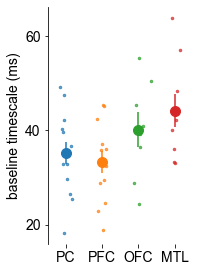

In [100]:
rl_short = ['PC', 'PFC', 'OFC', 'MTL']
plt.figure(figsize=(3,4))
for i_r, reg in enumerate(region_labels):
    plt.plot([i_r]*len(df_mean)+np.random.randn(len(df_mean))/10, df_mean[reg].values, '.', ms=5, alpha=0.7, color=C_ORD[i_r])
    plt.errorbar(i_r, df_mean[reg].mean(), df_mean[reg].sem(), color=C_ORD[i_r], fmt='o', ms=10, alpha=1)

         
plt.xticks(range(len(rl_short)), rl_short)
plt.yticks(np.arange(0.02,0.07, 0.02), (np.arange(0.02,0.07, 0.02)*1000).astype(int))
plt.ylabel('baseline timescale (ms)')
plt.xlim([-0.5, 3.5])
despine(bottom=True)
plt.tight_layout()
if save_plot: plt.savefig(fig_path%'tau_pre', bbox_inches='tight')

print('PC-MTL: ', ttest_ind(df_mean['Parietal'], df_mean['MTL'], nan_policy='omit'))
print('PFC-MTL: ', ttest_ind(df_mean['PFC'], df_mean['MTL'], nan_policy='omit'))
print('PFC-OFC: ', ttest_ind(df_mean['PFC'], df_mean['OFC'], nan_policy='omit'))

### Neuronal timescale across hierarchy is replicated
As expected, neuronal timescale increases along the cortical hierarchy. PC and PFC are both statistically different from MTL at baseline, but not from OFC or each other.

---
# Timescale change from prestimulus baseline to encoding period
Here, we look at the average timescale change (over channels and trials) between prestimulus period and delay period for each patient.

In [101]:
df_mean, df_sem, df_cc = collect_results(df_res_regions, region_labels, cond=2, feat='tau')

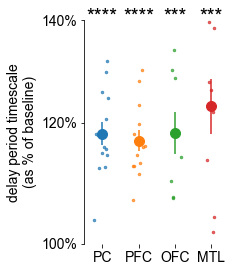

In [102]:
plt.figure(figsize=(3.5,4))
_, pv = ttest_1samp(df_mean, 0, nan_policy='omit') # compute all p-values
for i_r, reg in enumerate(region_labels):
    plt.plot([i_r]*len(df_mean)+np.random.randn(len(df_mean))/10, df_mean[reg].values, '.', ms=5, alpha=0.7, color=C_ORD[i_r])
    plt.errorbar(i_r, df_mean[reg].mean(), df_mean[reg].sem(), color=C_ORD[i_r], fmt='o', ms=10, alpha=1)
    s = echo_utils.sig_str(0, pv[i_r])
    plt.annotate(s[15:], xy=(i_r, 0.145), horizontalalignment='center', fontsize=20)

plt.xticks(range(len(rl_short)), rl_short)
# change axis to show percent change
yt = np.arange(1,1.41,0.2)
plt.yticks(log10(yt), ['%i%%'%int(yt_*100) for yt_ in yt]); plt.ylim(log10([yt[0], yt[-1]]))
plt.ylabel('delay period timescale\n(as % of baseline)')
despine(bottom=True); plt.xlim([-0.5, 3.5])
plt.tight_layout()
if save_plot: plt.savefig(fig_path%'tau_diff', bbox_inches='tight')

### Neuronal timescale is longer during working memory delay period
Neuronal timescale in all regions during delay period is on average 20% longer than during the prestimulus baseline period. Each small dot is a single subject and large circles/lines denote across-subject mean +/- sem.

These data support our hypothesis that neuronal timescale can be dynamically modulated, specifically lengthened during working memory encoding and delay period than at rest, and is true across all regions, not just frontal regions.

---
# Timescale difference vs. working memory accuracy
Next, we ask whether the extent of timescale modulation is related to working memory performance across individuals. 

Parietal 0.5115794246558464 0.061499878898265976
PFC 0.7503512515483205 0.0031288779369725394
OFC 0.07142857142857144 0.8665262706759088
MTL -0.4267819784654187 0.2519566902874007


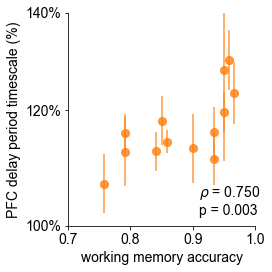

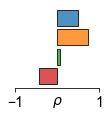

In [104]:
reg='PFC'

y = df_mean[reg][~np.isnan(df_mean[reg])]
y_err = df_sem[reg][~np.isnan(df_sem[reg])]
x = df_patient_info[['acc_identity','acc_spatial','acc_temporal']].mean(1)
rho, pv = spearmanr(x[y.index].values,y.values)

plt.figure(figsize=(4,4))
plt.errorbar(x[y.index].values, y.values, y_err.values, fmt='o', ms=8, alpha=0.8, color=C_ORD[1])
s = echo_utils.sig_str(rho, pv, form='text')
plt.annotate(s, xy=(0.7, 0.05), xycoords='axes fraction');
plt.yticks(log10(yt), ['%i%%'%int(yt_*100) for yt_ in yt]); plt.ylim(log10([yt[0], yt[-1]]))
plt.ylabel('PFC delay period timescale (%)')
plt.xticks(np.arange(0.7,1.01,0.1))
plt.xlabel('working memory accuracy')
despine();plt.tight_layout()
if save_plot: plt.savefig(fig_path%'PFC_taudiff_acc', bbox_inches='tight')

plt.figure(figsize=(1.5,1.5))
for i_r, reg in enumerate(region_labels):
    y = df_mean[reg][~np.isnan(df_mean[reg])]
    rho, pv = spearmanr(x[y.index].values,y.values)
    print(reg, rho, pv)
    plt.barh(len(region_labels)-i_r, rho, fc=C_ORD[i_r], ec='k', lw=1, alpha=0.8)
    s = echo_utils.sig_str(rho, pv)

plt.xticks([-1,1]); plt.xlabel(r'$\rho$', labelpad=-15)
plt.yticks([]); despine(left=True)
if save_plot: plt.savefig(fig_path%'corr_taudiff_acc', bbox_inches='tight')

### Timescale change in PFC and working memory performance are related
Average timescale change in PFC is significantly associated with average working memory performance across patients, and for no other region is this true even though all regions experience an increase in timescale. Top plot shows individual subject's change in PFC timescale and WM performance, and small bottom plot (inset in actual figure) shows Spearman correlation (rho) of timescale change and WM accuracy for each region in the brain (same color scheme as above).


---
### Checking other neural features

---------- exp ----------
Parietal -0.22050837269648552 0.4487251293055221
PFC -0.011034577228651771 0.9714598718066683
OFC -0.7857142857142858 0.020815127253525276
MTL -0.33473096350228926 0.37859496128192693
---------- tau ----------
Parietal 0.5115794246558464 0.061499878898265976
PFC 0.7503512515483205 0.0031288779369725394
OFC 0.07142857142857144 0.8665262706759088
MTL -0.4267819784654187 0.2519566902874007
---------- theta ----------
Parietal 0.41235065694242795 0.1428761061057796
PFC 0.5075905525179815 0.07660534777149673
OFC -0.09523809523809526 0.8225054302036114
MTL -0.5857791861290061 0.09743391135780573
---------- hfa ----------
Parietal -0.09481860025948877 0.7471279753178035
PFC -0.14620814827963596 0.6336333513519894
OFC 0.28571428571428575 0.4927262450169573
MTL 0.7113032974423645 0.03165655703330231


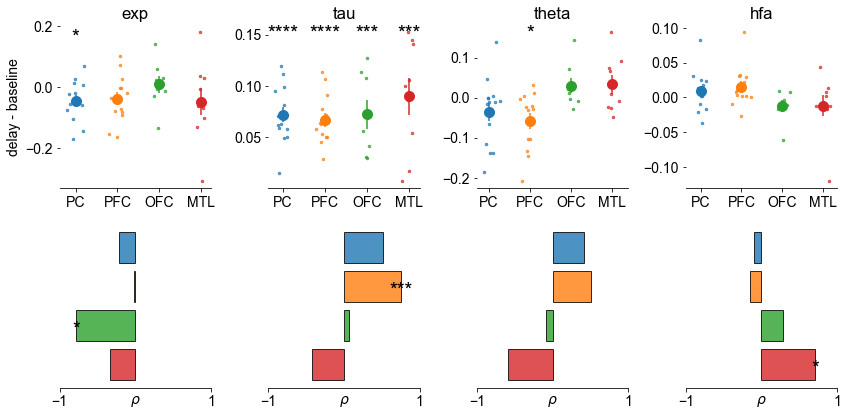

In [105]:
x = df_patient_info[['acc_identity','acc_spatial','acc_temporal']].mean(1)

plt.figure(figsize=(12,6))
for i_f, fn in enumerate(np.array(feature_names)[[1,3,4,5]]):
    df_mean, df_sem, df_cc = collect_results(df_res_regions, region_labels, cond=2, feat=fn)
    print('---------- %s ----------'%fn)
    plt.subplot(2,4,i_f+1)
    _, pv = ttest_1samp(df_mean, 0, nan_policy='omit') # compute all p-values
    for i_r, reg in enumerate(region_labels):
        plt.plot([i_r]*len(df_mean)+np.random.randn(len(df_mean))/10, df_mean[reg].values, '.', ms=5, alpha=0.7, color=C_ORD[i_r])
        plt.errorbar(i_r, df_mean[reg].mean(), df_mean[reg].sem(), color=C_ORD[i_r], fmt='o', ms=10, alpha=1)
        s = echo_utils.sig_str(0, pv[i_r])
        plt.annotate(s[15:], xy=(i_r, 0.145), horizontalalignment='center', fontsize=20)
        
    plt.title(fn)
    plt.xticks(range(len(rl_short)), rl_short)

    plt.subplot(2,4,i_f+5)
    for i_r, reg in enumerate(region_labels):
        y = df_mean[reg][~np.isnan(df_mean[reg])]
        rho, pv = spearmanr(x[y.index].values,y.values)
        print(reg, rho, pv)
        plt.barh(len(region_labels)-i_r, rho, fc=C_ORD[i_r], ec='k', lw=1, alpha=0.8)
        s = echo_utils.sig_str(0, pv)
        plt.annotate(s[15:], xy=(rho, len(region_labels)-i_r-0.25), horizontalalignment='center', fontsize=20)
        s = echo_utils.sig_str(rho, pv)

    plt.xticks([-1,1]); plt.xlabel(r'$\rho$', labelpad=-15)
    plt.yticks([]); despine(left=True)

plt.subplot(2,4,1); plt.ylabel('delay - baseline')
plt.tight_layout()
if save_plot: plt.savefig(fig_path%'corr_diff_all_features', bbox_inches='tight')

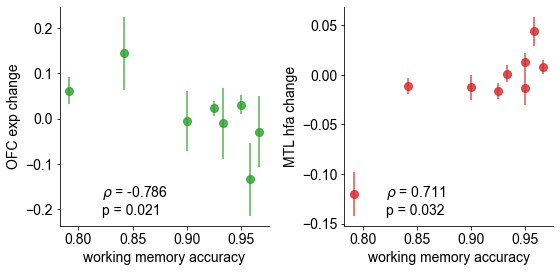

In [107]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
reg = 'OFC'
fn = 'exp'
df_mean, df_sem, df_cc = collect_results(df_res_regions, region_labels, cond=2, feat=fn)
y = df_mean[reg][~np.isnan(df_mean[reg])]
y_err = df_sem[reg][~np.isnan(df_sem[reg])]
rho, pv = spearmanr(x[y.index].values,y.values)
plt.errorbar(x[y.index].values, y.values, y_err.values, fmt='o', ms=8, alpha=0.8, color=C_ORD[2])
s = echo_utils.sig_str(rho, pv, form='text')
plt.annotate(s, xy=(0.2, 0.05), xycoords='axes fraction');
plt.ylabel('%s %s change'%(reg, fn))
plt.xlabel('working memory accuracy')

plt.subplot(1,2,2)
reg = 'MTL'
fn = 'hfa'
df_mean, df_sem, df_cc = collect_results(df_res_regions, region_labels, cond=2, feat=fn)
y = df_mean[reg][~np.isnan(df_mean[reg])]
y_err = df_sem[reg][~np.isnan(df_sem[reg])]
rho, pv = spearmanr(x[y.index].values,y.values)
plt.errorbar(x[y.index].values, y.values, y_err.values, fmt='o', ms=8, alpha=0.8, color=C_ORD[3])
s = echo_utils.sig_str(rho, pv, form='text')
plt.annotate(s, xy=(0.2, 0.05), xycoords='axes fraction');
plt.ylabel('%s %s change'%(reg, fn))
plt.xlabel('working memory accuracy')

despine();plt.tight_layout()

### No other feature is as strongly predictive of behavior as PFC timescale change.

---

# Supplemental & Fun

### Single Distribution of Timescale Ratios (Delay:Prestim)

In [13]:
# bins = np.arange(-3, 3, 0.1)
# plt.figure(figsize=(4,4))
# for i_p, df_patient in df_diff.groupby('patient'):
#     plt.hist(df_patient['tau'], bins, histtype='step', density=True)
    
# plt.hist(df_diff['tau'], bins, histtype='step', density=True, lw=1, color='k');
# #df_patient['tau']

### To Log or Not to Log

In [14]:
# plt.figure(figsize=(15,5))

# # door #1
# plt.subplot(1,3,1)
# df_pre = df_operating[df_operating['cond']==0]
# df_enc = (df_operating[df_operating['cond']==1]+df_operating[df_operating['cond']==2].values)/2
# df_diff = df_enc 
# df_diff[feature_names] -= df_pre[feature_names].values
# plt.hist(df_diff['tau'], 100);
# print((df_diff['tau']).mean(), (df_diff['tau']<=0).sum()/(~np.isnan(df_diff['tau'])).sum())
# print(ttest_1samp((df_diff['tau']), 0, nan_policy='omit'))
# print('------')

# # door #2
# plt.subplot(1,3,2)
# df_diff = log10(df_enc)
# df_diff[feature_names] -= log10(df_pre[feature_names].values)
# plt.hist(df_diff['tau'], 100);
# print((df_diff['tau']).mean(), (df_diff['tau']<=0).sum()/(~np.isnan(df_diff['tau'])).sum())
# print(ttest_1samp((df_diff['tau']), 0, nan_policy='omit'))
# print('------')

# # door #3
# plt.subplot(1,3,3)
# df_pre = log10(df_operating[df_operating['cond']==0])
# df_enc = (log10(df_operating[df_operating['cond']==1])+log10(df_operating[df_operating['cond']==2].values))/2
# df_diff = df_enc 
# df_diff[feature_names] -= df_pre[feature_names].values
# plt.hist(df_diff['tau'], 100);
# print((df_diff['tau']).mean(), (df_diff['tau']<=0).sum()/(~np.isnan(df_diff['tau'])).sum())
# print(ttest_1samp((df_diff['tau']), 0, nan_policy='omit'))
# print('------')



In [15]:
# plt.figure(figsize=(4,4))
# log_first = (log10(df_operating[df_operating['cond']==1])+log10(df_operating[df_operating['cond']==2].values))/2
# log_after = log10((df_operating[df_operating['cond']==1]+df_operating[df_operating['cond']==2].values)/2)
# plt.plot(log_first['tau'],log_after['tau'], '.', ms=1)
# plt.plot([-2.5,-0.5],[-2.5,-0.5], '--')
# plt.xlabel('log-first')
# plt.ylabel('log-after')
# # is this true in general?
# plt.figure(figsize=(4,4))
# a = np.random.lognormal(-4, 1.2, 30000)
# b = np.random.lognormal(-4, 1.2, 30000)
# plt.plot((log10(a)+log10(b))/2, log10((a+b)/2), '.', ms=1)
# plt.plot([-2.5,-0.5],[-2.5,-0.5], '--')

### Old Way of Compute with Outlier Removal 
(doesn't really make a difference)

In [16]:
# # outlier detection, doesn't really matter what you use beyond z = 3
# z_outlier = 5
# log_tau = True
# global_outlier = False # do outlier detection per subject or pooled, also makes no real difference

# df_operating = df_alltrials.copy()
# grand_avg = []
# valid_pat = np.unique(df_operating['patient'])

# if global_outlier:
#     # global outliers, discard based on tau outlier
#     x = df_operating['tau']
#     z = np.abs((x-np.nanmean(x))/np.nanstd(x))
#     df_operating.loc[z>z_outlier, feature_names]=np.nan

# # collect all patients
# for i_p in valid_pat:
#     # loop over patients
#     df_p = df_operating[(df_operating['patient']==i_p)].copy()
    
#     if not global_outlier:
#         # within subject outliers
#         x = df_p['tau']        
#         z = np.abs((x-np.nanmean(x))/np.nanstd(x))
#         df_p.loc[z>z_outlier, feature_names]=np.nan        
        
#     # pre-stim epoch
#     df_pre = df_p[df_p['cond']==0]
    
#     # get avg values for delay periods during encoding epoch
#     arr_enc = (df_p[df_p['cond']==1].values + df_p[df_p['cond']==2].values)/2    
#     df_enc = pd.DataFrame(arr_enc, columns=col_names, index=df_pre.index) 

#     # log timescale values because non-normal
#     if log_tau:
#         df_pre['tau'] = log10(df_pre['tau'])
#         df_enc['tau'] = log10(df_enc['tau'])
    
#     # compute feature diff and channel average across trials
#     f_collect = []
#     n_nans = 0
#     for g, g_df in df_pre.groupby('trial'):
#         f_pre = df_pre.loc[g_df.index][feature_names]
#         f_enc = df_enc.loc[g_df.index][feature_names]

#         # compute feature difference
#         f_diff = f_enc - f_pre
#         # average over channels
#         f_collect.append(np.nanmean(f_diff,0))
#         # count how many nans to estimate data quality
#         n_nans += np.isnan(f_diff).sum()['tau']

#     f_collect = np.array(f_collect)

#     # t-test on diff of measures
#     tval = ttest_1samp(f_collect, 0, nan_policy='omit')[0]
#     data_qual = (1-n_nans/len(df_pre))*100
    
#     # collect
#     grand_avg.append(np.concatenate(([data_qual], np.nanmean(f_collect, 0), tval)))
    
# grand_avg = np.array(grand_avg)

# # ----------

# # run stats
# df_result = pd.DataFrame(grand_avg, index=df_patient_info.index.values[patient_inds], 
#                          columns=['data_qual'] + [fn+'_diff' for fn in feature_names] + [fn+'_tval' for fn in feature_names])

# # pool behavioral data (average of RT and accuracy)
# df_patient = pd.concat((df_patient_info.loc[df_result.index], df_result), axis=1)
# df_patient['acc'] = df_patient[['acc_identity','acc_spatial','acc_temporal']].mean(1)
# df_patient['rt'] = df_patient[['rt_identity','rt_spatial','rt_temporal']].mean(1)

# # GLM on accuracy
# # mod = smf.ols(formula='acc ~ age + tau_diff + offset_diff + exp_diff + theta_diff + hfa_diff', data=df_patient)
# mod = smf.ols(formula='acc ~ age + tau_diff', data=df_patient)
# res = mod.fit()
# print(res.summary())

# # plot 
# x = df_patient['tau_diff']
# y = df_patient['acc']
# plt.figure(figsize=(4,4))
# plt.plot(x,y, 'ok', alpha=0.6, ms=8)
# plt.xlabel('Encoding - Baseline');plt.ylabel('Accuracy');
# plt.tight_layout(); despine()
# #if save_plot: plt.savefig(fig_path%'corr_tdiff_acc', bbox_inches='tight')

# print('-------------')
# print('Pearson:', pearsonr(x,y))
# print('Spearman: ', spearmanr(x,y,nan_policy='omit'))

# print('------------')
# print([fn+'_tval' for fn in feature_names])
# print(ttest_1samp(df_patient[[fn+'_tval' for fn in feature_names]], 0)[1])